# SmartSim

## 1.0) Demonstration of SmartSim + Jupyter
  - This simple example showcases how one could use SmartSim to connect models written in Fortran(or C, C++) to a Jupyter notebook to harness the full power of Python's data analytics stack.
  - This notebook was launched through the Urika Data Analytics stack which provides a Spark and/or Dask cluster for the notebook to use.
  - Since many users do not yet have access to the Urika stack, we do not demo those features here to show how this works with a vanilla Jupyter notebook

In [ ]:
import os
import reconstruct
import importlib
importlib.reload(reconstruct)
import matplotlib.pyplot as plt
import numpy as np

# Import SmartSim
from smartsim import Experiment, Client

## 1.1) Setup SmartSim Experiment

### Experiment
 - Experiment is the main API object created by SmartSim
 - Experiment is stateful and holds all the entities(models, orchestrator, nodes) created by the user.
 - To run the MOM6 Ocean model(Fortran), we create a model and define how it should be run.
 - The simulation uses our Fortran client which is already compiled into the model

### Launcher
 - SmartSim will calculate the size of the allocation based on the entities based to the `experiment.start()` function. If nothing is passed to start, all entities created in the experiment are launched, as is the case here.
 - We could have also used `experiment.add_allocation()` to add an existing allocation to the experiment or `experiment.get_allocation()` to get an allocation ahead of time.
 
 - We call `experiment._init_remote_launcher()` here as we are running on a compute node(`nid00099`), however, Slurm is only available on the login nodes. SmartSim uses a ZMQ server (must be launched seperately at the moment) hosted on the login node to field requests from any running SmartSim instance. In this fashion, SmartSim is able to get allocations, launch models, and release allocations from inside this notebook or a python script.
 - The ZMQ server in this case is launched on the login node at `10.128.0.18`
 
### Distributed In-Memory Database (KeyDB)
 - Lastly, we create the Orchestrator which is an multithreaded in-memory database, KeyDB
 - We launch the database on 10 nodes, one database per node
 - The database per node (`dpn`) argument can be used to launch more than one database on a single node. This can be useful in situations where nodes have excess memory and you want to increase throughput.


In [14]:
experiment = Experiment("MOM6-interaction")
experiment.init_remote_launcher(addr="10.128.0.18")
MOM6_settings= {
    "ppn": 48,
    "nodes": 36,
    "duration": "1:00:00",
    "executable": "/lus/snx11254/ashao/dev/MOM6-examples/build/gnu/ice_ocean_SIS2/repro/MOM6",
    "partition": "iv24"
}
experiment.create_model("MOM6", run_settings=MOM6_settings)
orc = experiment.create_orchestrator(cluster_size=10, dpn=1, partition="iv24")

## 1.2) Start experiment
  - `experiment.start()` is a non-blocking command so that interactive execution may follow
  - Here we see output confirming that we have obtained our allocation, and the in-memory database has been constructed.
  - If we already had an allocation, or got an allocation through smartsim prior to the call to start, we wouldve called `experiment.start(run_on_existing=True)`

In [15]:
experiment.start()

2020-04-14 21:54:55 nid00099 smartsim.experiment[16251] INFO Starting experiment: MOM6-interaction
2020-04-14 21:54:55 nid00099 smartsim.launcher.SlurmLauncher[16251] INFO Successfully validated Slurm with sufficient resources
2020-04-14 21:54:58 nid00099 smartsim.launcher.SlurmLauncher[16251] INFO Allocation successful with Job ID: 117358
2020-04-14 21:55:35 nid00099 smartsim.launcher.launcher[16251] INFO KeyDB Cluster has been created with 10 nodes


## 1.3) Initialize the SmartSim Client
  - In order to connect the Jupyter notebook to the simulation, we call experiment.create_connection() with the name of the model we want to connect to the notebook.
  - We signify `cluster=True` in the initialization of the client to inform the client that we should be interfacing with a clustered database.
  - Following this, we are able to intialize a client for communication between the notebook and the database where the simulation is storing information

In [16]:
experiment.create_connection("MOM6")
client = Client(cluster=True)
client.setup_connections()

## 1.4) Online Interaction with the Simulation
 - Below we will plot a few fields from the ocean model at specific time steps to get an idea of how the model is progressing.
 - The script we use to recontruct the domain is provided in the repository.
 - The serial verison of the recontruct script is shown for simplicity, but this computation is trivially parallelized.

Time elapsed in iteration: 15.366784572601318


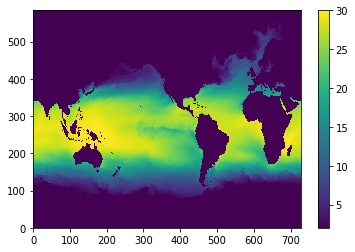

In [17]:
# beginning of the model
domain = reconstruct.reconstruct_domain(client, "63292802400.00", 1728)
plt.pcolormesh(domain[0,...])
plt.pcolormesh(domain[0,...], vmin=2, vmax=30)
plt.colorbar()

Time elapsed in iteration: 15.580456018447876


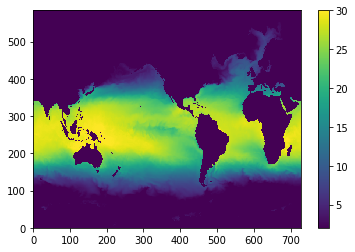

In [19]:
# Further into the simulation
domain = reconstruct.reconstruct_domain(client, "63293839200.00", 1728)
plt.pcolormesh(domain[0,...], vmin=2, vmax=30)
plt.colorbar()

## 1.5) Analyze Model progression
  - Here we will obtain the previous two time steps and plot the difference between them to see how the model is progressing over time.


In [21]:
domain_start = reconstruct.reconstruct_domain(client, "63292802400.00", 1728)
domain_15_days_in = reconstruct.reconstruct_domain(client, "63293839200.00", 1728)
difference = domain_start - domain_15_days_in

Time elapsed in iteration: 15.487463235855103
Time elapsed in iteration: 15.522371053695679


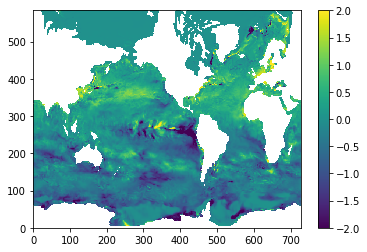

In [24]:
difference[difference == 0] = np.nan
plt.pcolormesh(difference[0,...], vmin=-2, vmax=2)
plt.colorbar()

## 1.6) Release the allocations that SmartSim has obtained
  - Now that we are done analyizing our model, we will release the allocations we obtained through a call to the experiment API.

In [11]:
experiment.release()

2020-04-14 21:54:19 nid00099 smartsim.control.controller[16251] INFO Releasing allocation: 117357
2020-04-14 21:54:19 nid00099 smartsim.launcher.launcher[16251] INFO Successfully freed allocation 117357
